In [34]:
# load in all t_vals (mean from cross val?)
# plot with channels with lowest p-val, 
# or sellect the ones with the highest t_vals peak (max()) - then we can update the location of these later

In [35]:
## LOAD AXIAL FIR RESULTS
import pandas as pd
import mne
import numpy as np
import matplotlib.pyplot as plt
import h5py
import re
from os.path import join
import pickle

def load_reg_pickle(pp, input_dir, prefix, subfolder='evoked'):
    """load pickle of regresion results
    input pp number, input diretory (before pp folder), and prefix of pickle file
    return results form pickle"""
    
    # construct folder name
    fullpath = join(input_dir, f'sub-{pp:03}', subfolder)
    reg_fn = f'{prefix}regression-sub-{pp:03}.pickle'

    with open(join(fullpath, reg_fn), 'rb') as handle:
        reg_results = pickle.load(handle)
    return(reg_results)


def gen_df_dict(d, stat='t_val'):
    """place pp data of stat of interest into a pandas dataframe"""

    # Load the layout information
    layout = mne.channels.read_layout('CTF275.lay').names
    layout.append('pp')
    layout.append('timepoint')
    # put in df
    dataframe_dummy = pd.DataFrame(columns=layout)
    # nest in df dict
    df_dict = {key : dataframe_dummy  for key in d[0][4]['mean'][stat].keys()}

    # loop over keys
    for it in df_dict.keys():

        # loop over pps
        for pp_idx in range(len(pps)):
            # actract array for current pp
            current_ar = d[pp_idx][4]['mean'][stat][it]   # 'FIR_surprisal' for now, loop later

            # Use list comprehension to filter out strings that end with '-4304'
            filtered_list = [s for s in MNE_evokeds[pp_idx][0].ch_names if s.endswith("-4304")]
            filtered_list = [re.sub(r"-4304$", '', s) for s in filtered_list]
            pp = pps[pp_idx]

            # plot dataframe
            df_temp = pd.DataFrame(current_ar, columns=filtered_list)
            df_temp['pp'] = pp
            df_temp['timepoint'] = df_temp.index.to_numpy()

            # append to concat
            df_dict[it] = pd.concat([df_dict[it], df_temp], ignore_index=True, sort=False)
    return(df_dict)

In [36]:
def create_dummy_info():
    # Step 1: Read the layout
    layout = mne.channels.read_layout('CTF275.lay')

    # Step 2: Create channel information
    # Assuming all channels are MEG channels
    ch_names = layout.names
    ch_types = ['mag'] * len(ch_names)  # Adjust if you have different types of channels

    info = mne.create_info(ch_names=ch_names, sfreq=60, ch_types=ch_types)
    info._unlocked = True
    info['highpass'] = 0.0
    info['lowpass'] = 600.0
    return(info)

## load files for all pp

In [91]:
pps = [1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14]
input_dir = f'/project/3018063.01/preproc'

# load all firs
prefix = 'FIR_'
all_FIRs = [load_reg_pickle(pp, input_dir, prefix) for pp in pps]
    # 0: rawscores
    # 1: scores
    # 2: non-cv rawscores
    # 3: non-cv scores
    # 4: meanscores
    
# load all mnes
prefix = 'MNE_'  
all_MNEs = [load_reg_pickle(pp, input_dir, prefix) for pp in pps]
    # 'beta', 'stderr', 't_Val', 'p_val', 'mlog10_p_val'   +    
    # 'FIR_onoff', 'forward_adapted_activation', 'surprisal', 'pred_prob'
    
# load mne evoked objects
MNE_evokeds = [mne.read_evokeds(f'/project/3018063.01/preproc/sub-{pp:03}/evoked/MNE_regression-sub-{pp:03}.fif') for 
               pp in pps]

In [39]:
# load gradient information
#all_grads = [load_grad_mat(pp, MNE_evokeds[0][0], input_dir) for pp in pps]

In [84]:
import os

# settings
task = 0     # 0: main, 1: localizer
loc_run = 1  # run 1 or run 2

# MEG directory and file names
tasks = ['main', 'loc']
prefix = ''
# OPTION A. use mne reg
ev_nm = ['FIR_onoff', 'forward_adapted_activation', 'pred_prob', 'surprisal']
    
# OPTION B. use own reg
evs = MNE_evokeds[0]
    
# loop over evoked and prepair for exporting to matlab
for ev in evs:
    
    # remove suffix
    ev.info._unlocked = True   # unlock to prevent safety checks and be able to change info as desired
    ev.info['ch_names'] = [ch_name.replace('-4304', '') if '-4304' in 
                               ch_name else ch_name for ch_name in ev.info['ch_names']]
    ev.info['chs'] = [{**ch, 'ch_name': ch['ch_name'].replace('-4304', '')} if '-4304' in 
                          ch['ch_name'] else ch for ch in ev.info['chs']]

    # Also, update the montage if it exists
    if ev.info['dig'] is not None:
        for d in ev.info['dig']:
            if 'ch_name' in d and '-4304' in d['ch_name']:
                d['ch_name'] = d['ch_name'].replace('-4304', '')

In [99]:
def load_grad_mat(pp, ev, input_dir, file_names):

    #predefine dict
    evokeds_out = {}

    # loop over all file names
    for f_idx in range(len(file_names)):
        fn = file_names[f_idx]
        f_path = f'{input_dir}/sub-{pp:03}/evoked/{fn}-sub-{pp:03}.mat'

        # load actual evoked
        evokeds_out[f_idx] = mne.read_evoked_fieldtrip(f_path, ev.info)
        evokeds_out[f_idx].comment = f'{fn}'
    return(evokeds_out)

In [100]:
file_names = ['grad_FIR_forward_adapted_activation', 'grad_FIR_onoff', 
                 'grad_FIR_pred_prob', 'grad_FIR_surprisal']
file_names = ['grad_MNE_forward_adapted_activation', 'grad_MNE_FIR_onoff', 
                 'grad_MNE_pred_prob', 'grad_MNE_surprisal']

all_grads = [load_grad_mat(pp, MNE_evokeds[0][0], input_dir, file_names) for pp in pps]

/scratch/jorvhar/50818721.dccn-l029.dccn.nl/ipykernel_11111/1108465531.py:12: RuntimeWarning: The following channels are present in the FieldTrip data but cannot be found in the provided info: {'MLT31', 'MRO41'}.
These channels will be removed from the resulting data!
  evokeds_out[f_idx] = mne.read_evoked_fieldtrip(f_path, ev.info)
/scratch/jorvhar/50818721.dccn-l029.dccn.nl/ipykernel_11111/1108465531.py:12: RuntimeWarning: The following channels are present in the FieldTrip data but cannot be found in the provided info: {'MLT31', 'MRO41'}.
These channels will be removed from the resulting data!
  evokeds_out[f_idx] = mne.read_evoked_fieldtrip(f_path, ev.info)
/scratch/jorvhar/50818721.dccn-l029.dccn.nl/ipykernel_11111/1108465531.py:12: RuntimeWarning: The following channels are present in the FieldTrip data but cannot be found in the provided info: {'MLT31', 'MRO41'}.
These channels will be removed from the resulting data!
  evokeds_out[f_idx] = mne.read_evoked_fieldtrip(f_path, ev.i

/scratch/jorvhar/50818721.dccn-l029.dccn.nl/ipykernel_11111/1108465531.py:12: RuntimeWarning: The following channels are present in the FieldTrip data but cannot be found in the provided info: {'MLT31', 'MRO41'}.
These channels will be removed from the resulting data!
  evokeds_out[f_idx] = mne.read_evoked_fieldtrip(f_path, ev.info)
/scratch/jorvhar/50818721.dccn-l029.dccn.nl/ipykernel_11111/1108465531.py:12: RuntimeWarning: The following channels are present in the FieldTrip data but cannot be found in the provided info: {'MLT31', 'MRO41'}.
These channels will be removed from the resulting data!
  evokeds_out[f_idx] = mne.read_evoked_fieldtrip(f_path, ev.info)
/scratch/jorvhar/50818721.dccn-l029.dccn.nl/ipykernel_11111/1108465531.py:12: RuntimeWarning: The following channels are present in the FieldTrip data but cannot be found in the provided info: {'MRO41'}.
These channels will be removed from the resulting data!
  evokeds_out[f_idx] = mne.read_evoked_fieldtrip(f_path, ev.info)
/scr

## do over pp analyses

In [40]:
df_dict = gen_df_dict(all_FIRs, stat='t_val')

In [41]:
df = df_dict['FIR_surprisal'].groupby('timepoint').mean()
df = df.drop('pp', axis=1)

data = df.to_numpy()

In [42]:
info = create_dummy_info()

In [43]:
evoked = mne.EvokedArray(data.T, info, tmin=MNE_evokeds[0][0].tmin, baseline=(-0.02, 0.02))

Applying baseline correction (mode: mean)


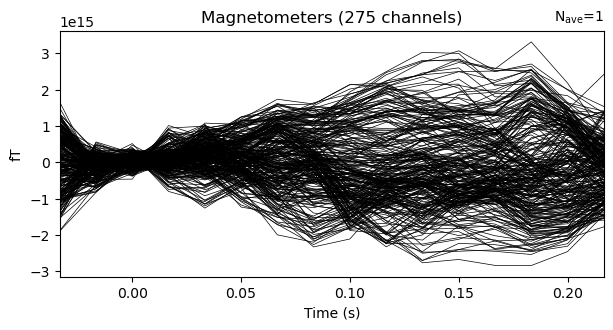

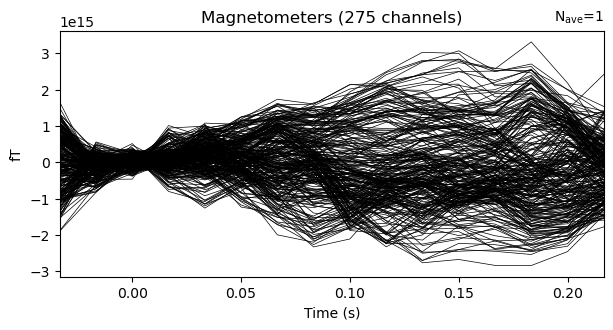

In [44]:
evoked.plot()

In [45]:
data = MNE_evokeds[0][12].get_data()
ch_nms = MNE_evokeds[0][12].info['ch_names']

In [46]:

# Load the layout information
layout = mne.channels.read_layout('CTF275.lay').names
layout.append('pp')
layout.append('timepoint')
# put in df
dataframe_dummy = pd.DataFrame(columns=layout)

#     # loop over pps
for pp_idx in range(len(pps)):
    # actract array for current pp
    current_ar = MNE_evokeds[pp_idx][12].get_data()
    ch_nms = MNE_evokeds[pp_idx][12].info['ch_names']

    # Use list comprehension to filter out strings that end with '-4304'
    filtered_list = ch_nms
    filtered_list = [re.sub(r"-4304$", '', s) for s in filtered_list]
 
    # get pp idx
    pp = pps[pp_idx]

    # plot dataframe
    df_temp = pd.DataFrame(current_ar.T, columns=filtered_list)
    df_temp['pp'] = pp
    df_temp['timepoint'] = df_temp.index.to_numpy()

    # append to concat
    dataframe_dummy = pd.concat([dataframe_dummy, df_temp], ignore_index=True, sort=False)



# get grad data into numpy - to average
# data = MNE_evokeds[0][12].get_data()


Applying baseline correction (mode: mean)


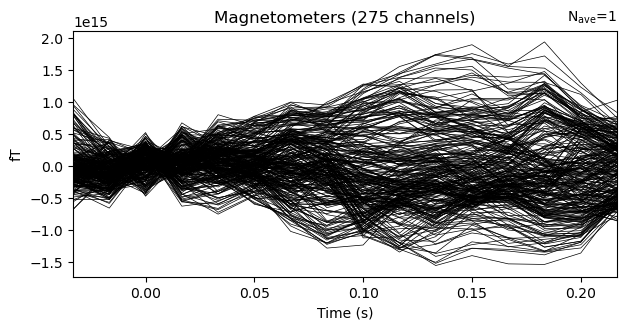

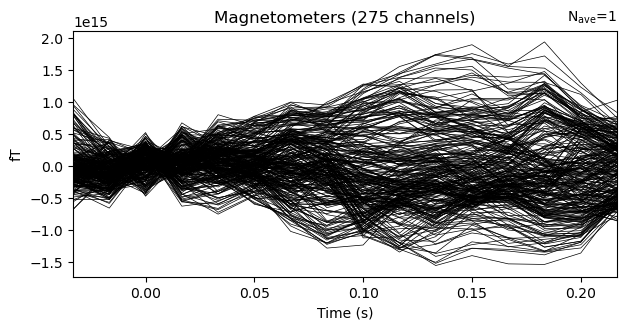

In [47]:
col_oi = mne.channels.read_layout('CTF275.lay').names
col_oi.append('timepoint')

# avarage data
df = dataframe_dummy[col_oi].groupby('timepoint').mean()
data = df.to_numpy()

evoked = mne.EvokedArray(data.T, info, tmin=MNE_evokeds[0][0].tmin, baseline=(-0.02, 0.02))
evoked.plot()

In [48]:
data.shape

(16, 275)

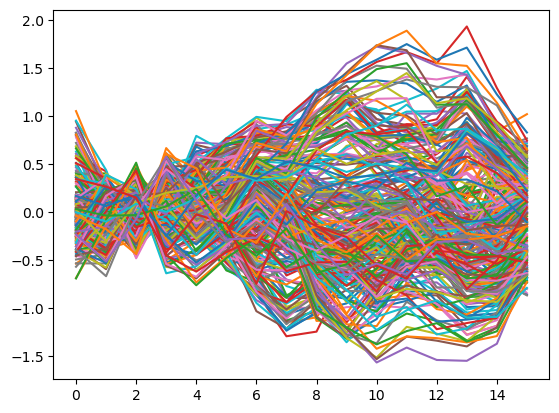

In [49]:
%matplotlib inline
plt.plot(data)

In [33]:
dataframe_dummy

MLC11     MLC12     MLC13     MLC14     MLC15     MLC16     MLC17  \
0    1.354761  0.626953  0.788926   0.32518  0.019575 -0.133465 -0.040464   
1    1.698451  0.801675  0.615198  -0.18384 -0.473637 -0.675799 -0.820711   
2   -2.105427 -1.377958 -1.342433 -0.908362 -0.745607 -0.597435 -0.462273   
3   -0.151887  0.207414  0.340279  0.814639  0.969223  1.068924  1.120164   
4    2.700109  2.905738  2.850617  2.426649  1.216999  1.203621   0.84402   
..        ...       ...       ...       ...       ...       ...       ...   
187 -0.627185  0.578768 -0.975253 -0.445255 -0.419331 -0.600523 -0.381145   
188 -1.358977 -1.623034 -1.110156 -0.828765 -0.351895   0.05038  0.111744   
189 -1.660169 -1.383016 -2.007403 -1.236762 -1.101969 -0.375724  -0.26469   
190 -1.240116 -1.619524 -1.812352 -1.443456 -1.358837 -1.304936 -1.017767   
191 -0.835622 -0.771588 -1.909381 -1.337685 -1.424276 -1.385638 -1.416126   

        MLC21     MLC22     MLC23  ...  pp timepoint FIR_frequencies  \
0    0.105897  0.335352   0.01379  ...   1         0         0.00000   
1    0.108304 -0.511655 -1.096185  ...   1         1         0.00000   
2   -0.922625 -1.113068 -0.260604  ...   1         2        11.00107   
3    0.572113  1.295775  1.273215  ...   1         3         0.00000   
4    3.283477  3.139381   2.56102  ...   1         4         0.00000   
..        ...       ...       ...  ...  ..       ...             ...   
187 -0.904453 -0.872731 -0.949409  ...  14        11         0.00000   
188 -1.596651 -1.047376 -0.615431  ...  14        12         0.00000   
189 -1.766953 -1.342016 -1.142379  ...  14        13         0.00000   
190 -2.207555 -2.076187 -2.092435  ...  14        14         0.00000   
191 -1.423149 -1.209016 -1.348192  ...  14        15         0.00000   

    FIR_frequencies_oct FIR_forward_adapation FIR_forward_adapted_activation  \
0              0.000000              0.000000                       0.000000   
1              0.000000              0.000000                       0.000000   
2              6.974205             18.894243                      18.784082   
3              0.000000              0.000000                       0.000000   
4              0.000000              0.000000                       0.000000   
..                  ...                   ...                            ...   
187            0.000000              0.000000                       0.000000   
188            0.000000              0.000000                       0.000000   
189            0.000000              0.000000                       0.000000   
190            0.000000              0.000000                       0.000000   
191            0.000000              0.000000                       0.000000   

    FIR_surprisal FIR_pred_prob FIR_onoff     onoff  
0        0.000000      0.000000  0.000000  0.000000  
1        0.000000      0.000000  0.000000  0.000000  
2      705.065491    117.800003  3.319331  3.319331  
3        0.000000      0.000000  0.000000  3.319331  
4        0.000000      0.000000  0.000000  3.319331  
..            ...           ...       ...       ...  
187      0.000000      0.000000  0.000000  4.304144  
188      0.000000      0.000000  0.000000  4.304144  
189      0.000000      0.000000  0.000000  4.304144  
190      0.000000      0.000000  0.000000  0.586029  
191      0.000000      0.000000  0.000000  0.000000  

[192 rows x 285 columns]

In [102]:
# Load the layout information
layout = mne.channels.read_layout('CTF275.lay').names
layout.append('pp')
layout.append('timepoint')
# put in df
dataframe_dummy = pd.DataFrame(columns=layout)

#     # loop over pps
for pp_idx in range(len(pps)):
    # actract array for current pp
    current_ar = all_grads[pp_idx][1].get_data()
    ch_nms = all_grads[pp_idx][1].info['ch_names']

    # Use list comprehension to filter out strings that end with '-4304'
    filtered_list = ch_nms
    filtered_list = [re.sub(r"-4304$", '', s) for s in filtered_list]
 
    # get pp idx
    pp = pps[pp_idx]

    # plot dataframe
    df_temp = pd.DataFrame(current_ar.T, columns=filtered_list)
    df_temp['pp'] = pp
    df_temp['timepoint'] = df_temp.index.to_numpy()

    # append to concat
    dataframe_dummy = pd.concat([dataframe_dummy, df_temp], ignore_index=True, sort=False)

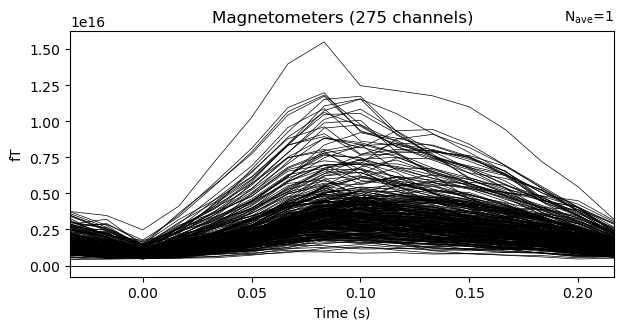

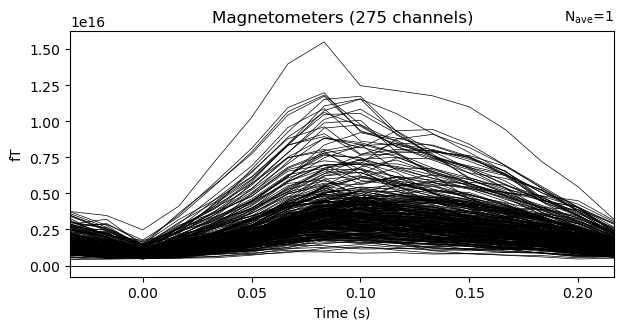

In [103]:
col_oi = mne.channels.read_layout('CTF275.lay').names
col_oi.append('timepoint')

# avarage data
df = dataframe_dummy[col_oi].groupby('timepoint').mean()
data = df.to_numpy()
data = np.nan_to_num(data)

evoked = mne.EvokedArray(data.T, info, tmin=MNE_evokeds[0][0].tmin ) #, baseline=(-0.02, 0.02))
evoked.plot()

In [108]:
all_grads[pp_idx][]

{0: <Evoked | 'grad_MNE_forward_adapted_activation' (average, N=1), 0 – 0.25 s, baseline off, 266 ch, ~295 kB>,
 1: <Evoked | 'grad_MNE_FIR_onoff' (average, N=1), 0 – 0.25 s, baseline off, 266 ch, ~295 kB>,
 2: <Evoked | 'grad_MNE_pred_prob' (average, N=1), 0 – 0.25 s, baseline off, 266 ch, ~295 kB>,
 3: <Evoked | 'grad_MNE_surprisal' (average, N=1), 0 – 0.25 s, baseline off, 266 ch, ~295 kB>}

In [121]:
def grad_df(cond_idx):

    # Load the layout information
    layout = mne.channels.read_layout('CTF275.lay').names
    layout.append('pp')
    layout.append('timepoint')
    # put in df
    dataframe_dummy = pd.DataFrame(columns=layout)

    #     # loop over pps
    for pp_idx in range(len(pps)):
        # actract array for current pp
        current_ar = all_grads[pp_idx][cond_idx].get_data()
        ch_nms = all_grads[pp_idx][cond_idx].info['ch_names']

        # Use list comprehension to filter out strings that end with '-4304'
        filtered_list = ch_nms
        filtered_list = [re.sub(r"-4304$", '', s) for s in filtered_list]

        # get pp idx
        pp = pps[pp_idx]

        # plot dataframe
        df_temp = pd.DataFrame(current_ar.T, columns=filtered_list)
        df_temp['pp'] = pp
        df_temp['timepoint'] = df_temp.index.to_numpy()

        # append to concat
        dataframe_dummy = pd.concat([dataframe_dummy, df_temp], ignore_index=True, sort=False)
    return(dataframe_dummy)

In [249]:
grad_fir_df = grad_df(1)[['MRT24', 'MRT23',  'MLT24', 'MLT23', 'MLT34', 'pp', 'timepoint']]
grad_adapt_df = grad_df(0)[['MRT24', 'MRT23', 'MRT34', 'MLT24', 'MLT23', 'MLT34', 'pp', 'timepoint']]
grad_pred_df = grad_df(2)[['MRT21', 'MRT25', 'MLT21', 'MLT25', 'pp', 'timepoint']]
grad_surp_df = grad_df(3)[['MRT35', 'MRT44', 'MRT43', 'MRT34', 'pp', 'timepoint']]

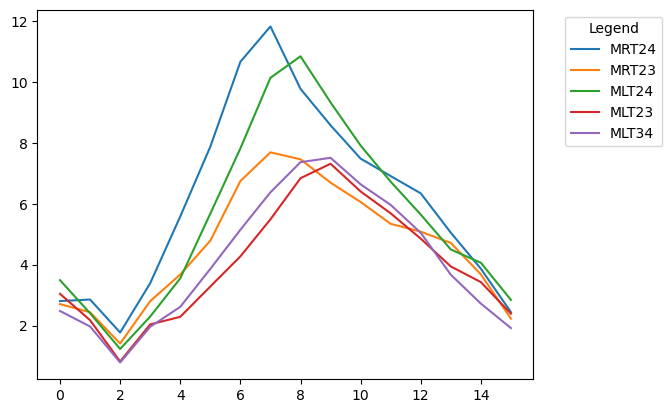

In [243]:
colum = grad_fir_df.groupby('timepoint').mean().drop(['pp'], axis=1).columns
plt.plot(grad_fir_df.groupby('timepoint').mean().drop(['pp'], axis=1), label=colum)
# Add a legend
plt.legend(title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

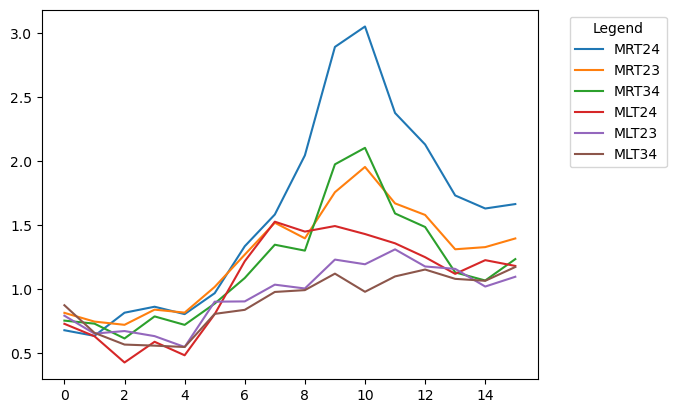

In [245]:
colum = grad_adapt_df.groupby('timepoint').mean().drop(['pp'], axis=1).columns
plt.plot(grad_adapt_df.groupby('timepoint').mean().drop(['pp'], axis=1), label=colum)
# Add a legend
plt.legend(title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

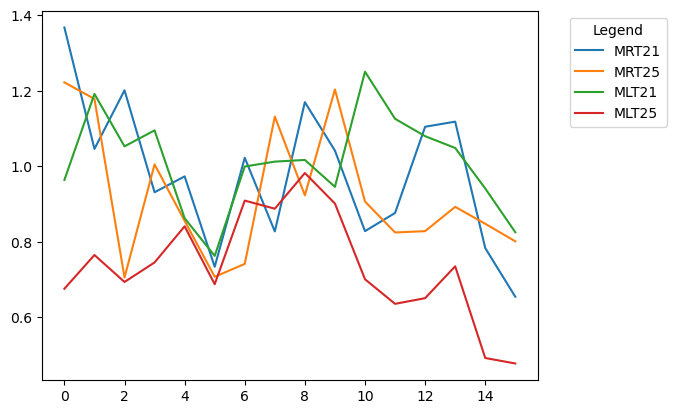

In [246]:
colum = grad_pred_df.groupby('timepoint').mean().drop(['pp'], axis=1).columns
plt.plot(grad_pred_df.groupby('timepoint').mean().drop(['pp'], axis=1), label=colum)
# Add a legend
plt.legend(title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

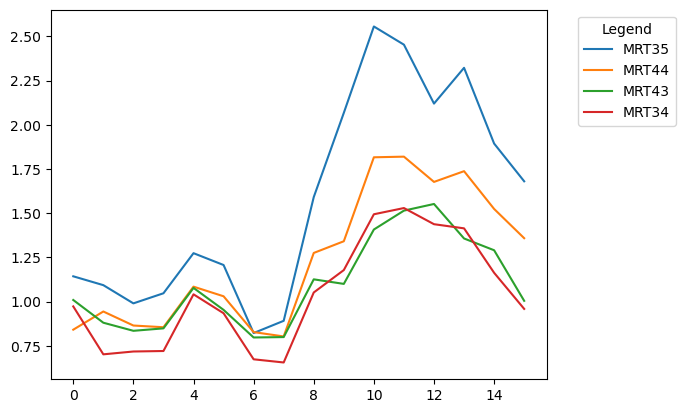

In [250]:
colum = grad_surp_df.groupby('timepoint').mean().drop(['pp'], axis=1).columns
plt.plot(grad_surp_df.groupby('timepoint').mean().drop(['pp'], axis=1), label=colum)
# Add a legend
plt.legend(title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [215]:
def pd_to_array(df):
    """and take mean over axis=0 / sensor level"""
    fullarray = np.zeros([len(df['pp'].unique()), len(df['timepoint'].unique())])

    idx = 0
    for pp in df['pp'].unique():
        pp_array = df[df['pp'] == pp].drop(['pp', 'timepoint'], axis=1).to_numpy().T
        pp_mean = np.mean(pp_array, axis=0)

        # append arrays
        fullarray[idx, :] = pp_mean

        idx += 1
        
    return(fullarray)

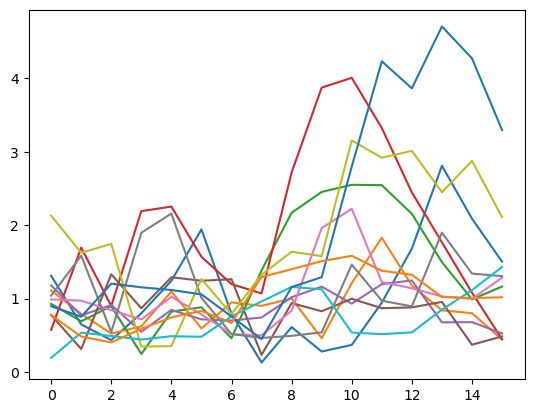

In [255]:
plt.plot(pd_to_array(grad_surp_df).T)

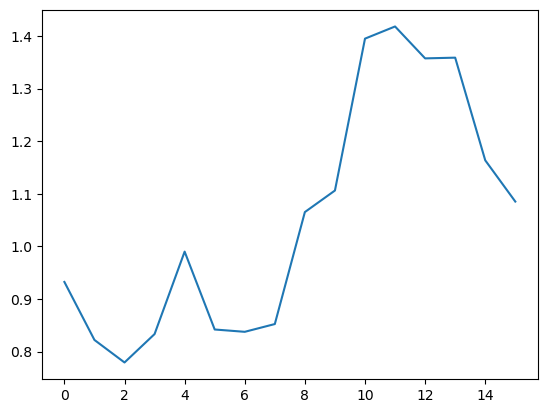

In [183]:
# plt.plot(fullarray.T)
plt.plot(fullarray.mean(axis=0))

In [182]:
fullarray.mean(axis=0)

array([0.9325105 , 0.82222524, 0.77941832, 0.83344188, 0.9901601 ,
       0.84212063, 0.83770389, 0.85247145, 1.06535893, 1.1063125 ,
       1.39503484, 1.41816195, 1.35752414, 1.35887701, 1.16372597,
       1.08531459])

In [ ]:
# now bootstrap points 

In [256]:
grad_fir_df 
grad_adapt_df 
grad_pred_df 
grad_surp_df

MRT35     MRT44     MRT43     MRT34  pp timepoint
0    1.815316   0.91717  1.074847  1.436349   1         0
1    0.647097    0.5664  0.969412  0.412644   1         1
2    0.683769  0.456375   0.46589  0.133722   1         2
3    0.765811  0.749968  1.269558  0.415544   1         3
4       1.545  1.477596   0.87341  1.075623   1         4
..        ...       ...       ...       ...  ..       ...
187  1.978429  1.567583  0.884802   1.08628  14        11
188  1.587697  1.491521  1.072053  1.145766  14        12
189  1.620081  1.133402  0.526285  0.805639  14        13
190  1.668667  0.990403  0.715225   0.65371  14        14
191  1.959403  1.263075  0.138448  0.710644  14        15

[192 rows x 6 columns]

In [ ]:
all_MNEs[pp_idx]['p_val_FIR_onoff']
all_MNEs[pp_idx]['p_val_forward_adapted_activation']
all_MNEs[pp_idx]['p_val_surprisal']

In [351]:

# grad_fir_df = grad_df(1)[['MRT24', 'MRT23',  'MLT24', 'MLT23', 'MLT34', 'pp', 'timepoint']]
# grad_adapt_df = grad_df(0)[['MRT24', 'MRT23', 'MRT34', 'MLT24', 'MLT23', 'MLT34', 'pp', 'timepoint']]
# grad_pred_df = grad_df(2)[['MRT21', 'MRT25', 'MLT21', 'MLT25', 'pp', 'timepoint']]
# grad_surp_df = grad_df(3)[['MRT35', 'MRT44', 'MRT43', 'MRT34', 'pp', 'timepoint']]

all_p = np.zeros([len(pps), 16])

for pp_idx in range(len(pps)):

    # select items
    pvalz = all_MNEs[pp_idx]['p_val_FIR_onoff']
    layout = mne.channels.read_layout('CTF275.lay').names

    # get indexes of items of interest
    ite = ['MRT24', 'MRT23',  'MLT24', 'MLT23', 'MLT34']
    ite_idx = [layout.index(item) for item in layout if item in ite]

    # take pvals
    all_p[pp_idx, :] = pvalz[ite_idx,:].mean(axis=0)
    
# get sig area
getsigvals = np.where(all_p.mean(axis=0) < 0.1)
getsigvals

(array([ 6,  7,  8,  9, 10, 11, 12]),)

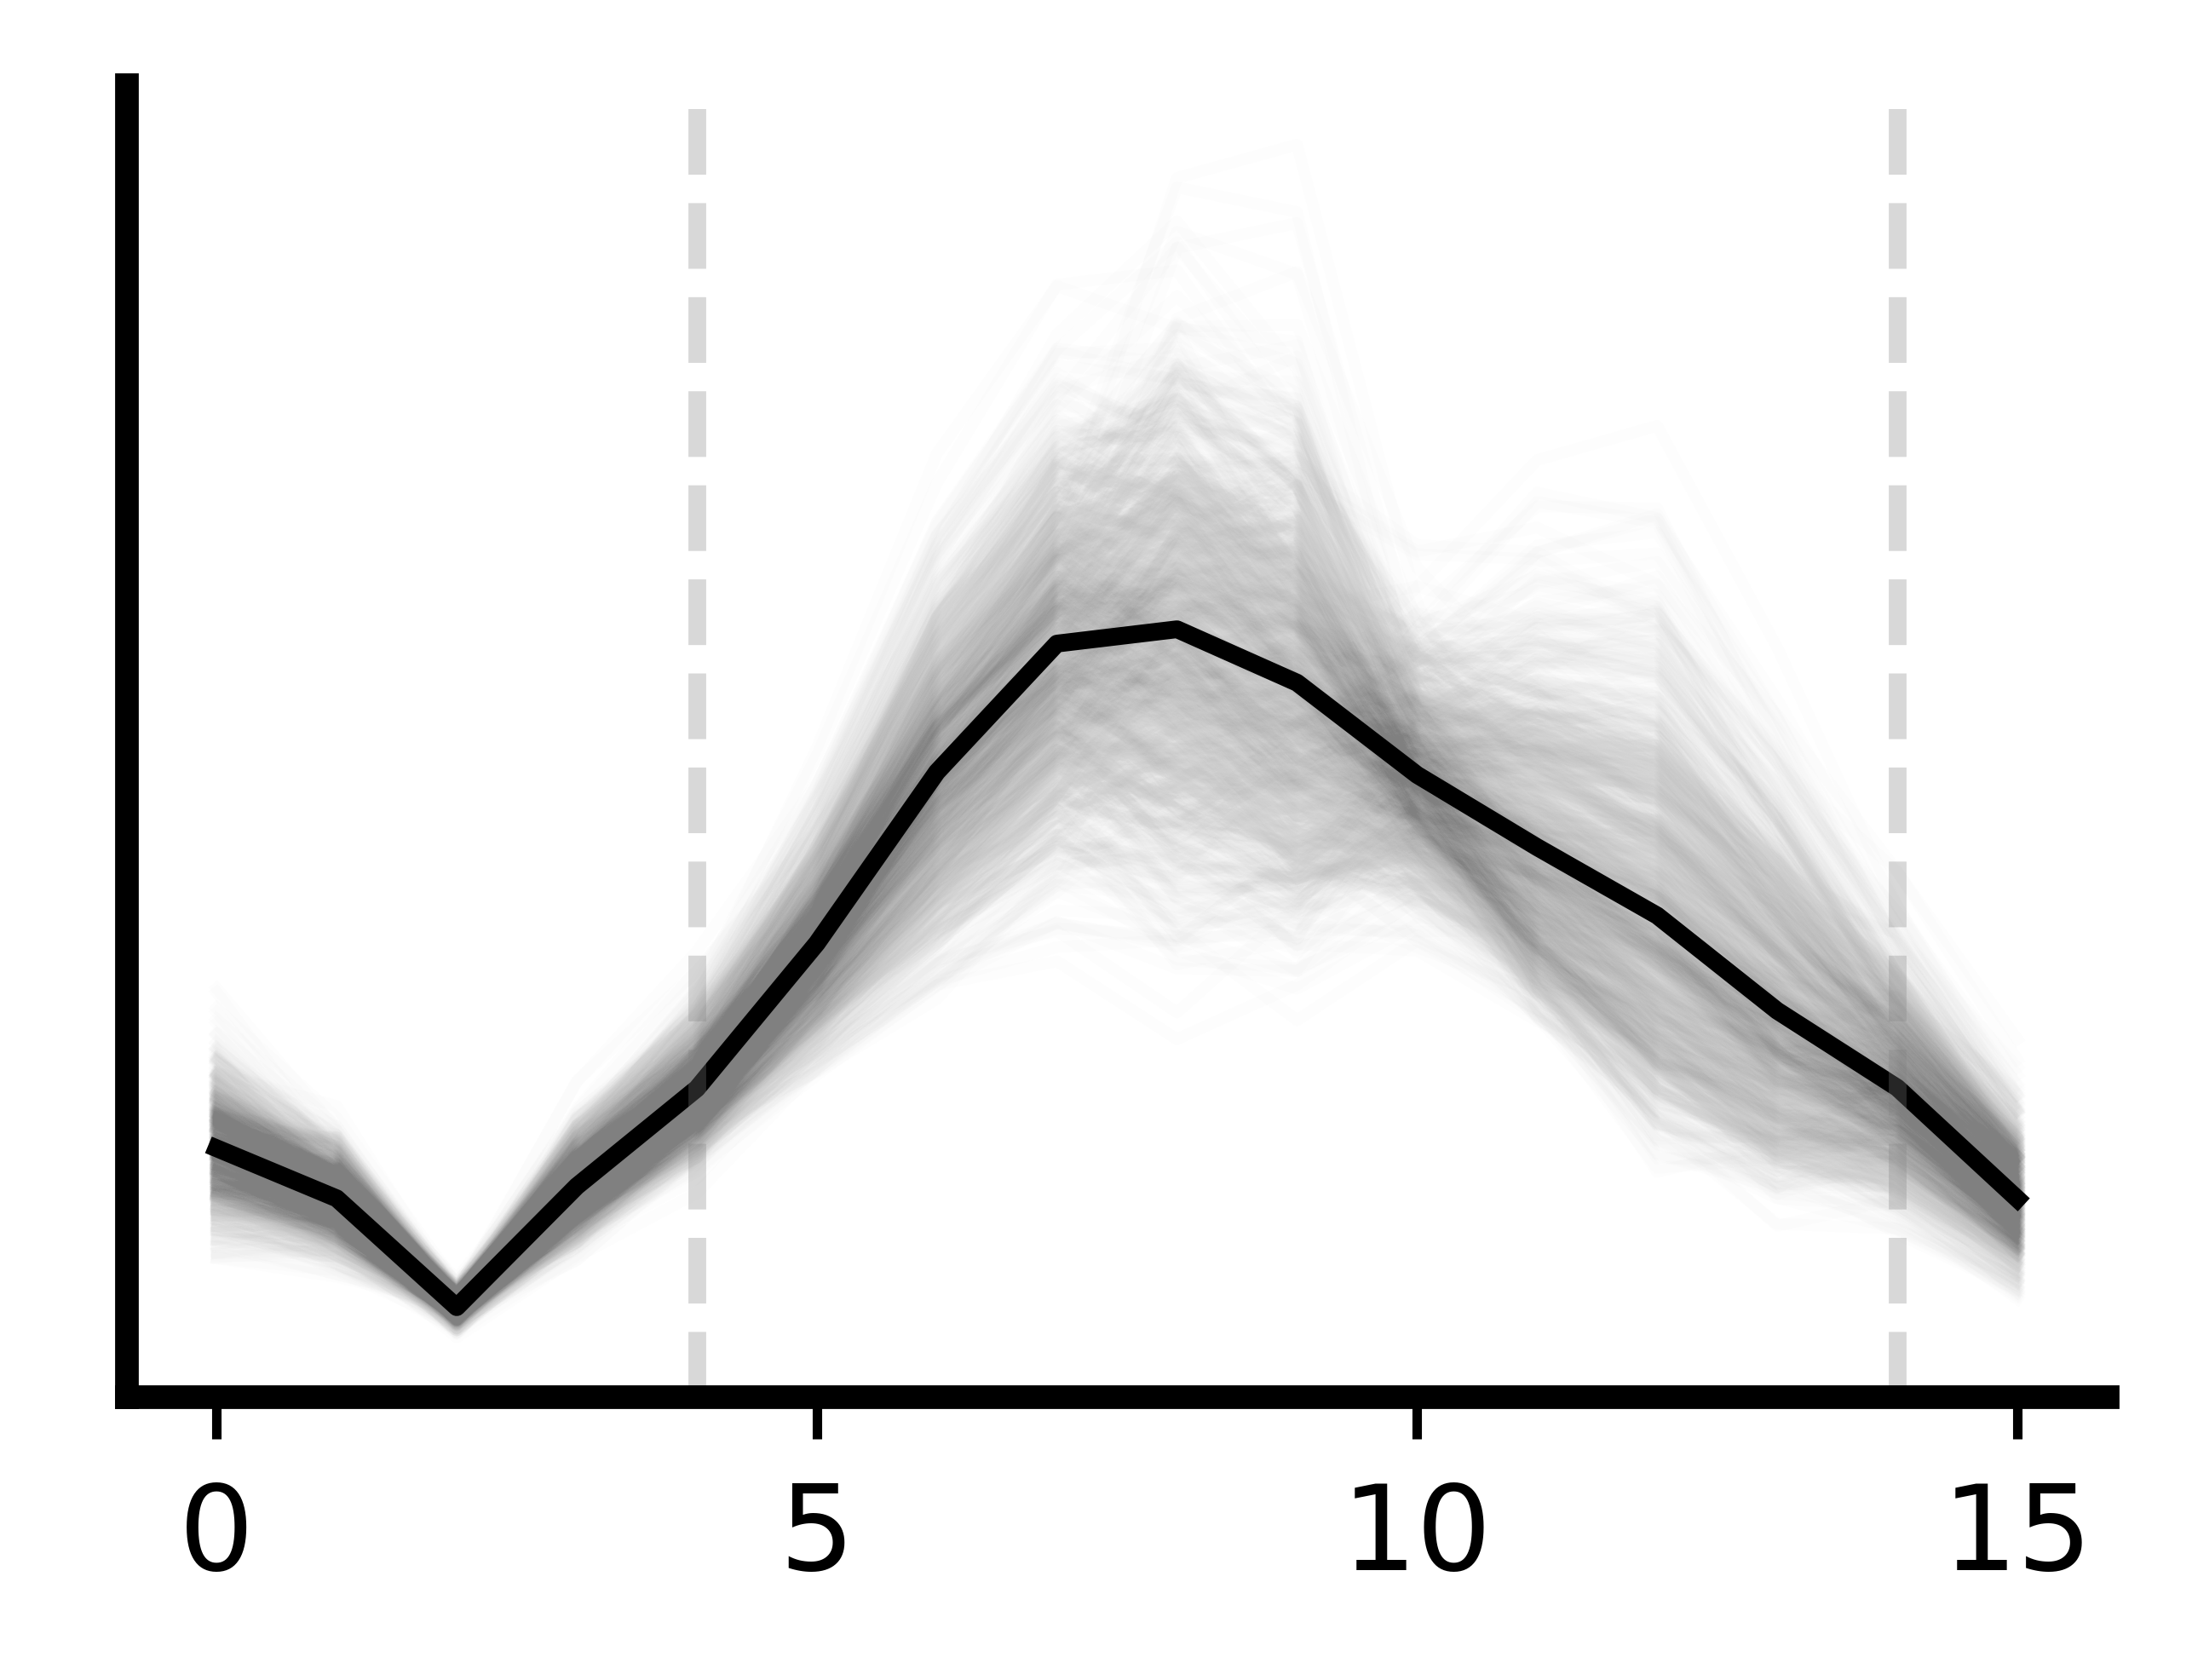

In [396]:
from scipy.interpolate import interp1d

fullarray = pd_to_array(grad_fir_df)

fig = plt.figure(figsize=(3,2), dpi=1000)

abc = bootstrap_resample(fullarray, bootnum=1000)
plt.plot(np.mean(abc, axis=1).T, alpha=0.01, lw=1, color='grey')
# plt.plot(data.T,marker='o', linestyle='None')

# calculate conf interval
# cil, cir = bootstrap_ci(fullarray)
# plt.plot(cil, color='black', alpha=0.3, ls='--')
# plt.plot(cir, color='black', alpha=0.3, ls='--')
plt.plot(fullarray.mean(axis=0), color='black')

# Remove y-axis numbers
plt.yticks([])
# plt.xticks([])
# plt.xticks([1, 2, 3, 4]) 
plt.locator_params(nbins=5)

# Customize plot borders
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove top border
ax.spines['right'].set_visible(False)  # Remove right border
ax.spines['left'].set_linewidth(2)  # Make left border thicker
ax.spines['bottom'].set_linewidth(2)  # Make bottom border thicker

ax.axvline(4, color='grey', lw=1.5, alpha=0.3, ls='--')
ax.axvline(14, color='grey', lw=1.5, alpha=0.3, ls='--')


plt.show()


In [390]:
evoked.times * 1000

array([-33.33333333, -16.66666667,   0.        ,  16.66666667,
        33.33333333,  50.        ,  66.66666667,  83.33333333,
       100.        , 116.66666667, 133.33333333, 150.        ,
       166.66666667, 183.33333333, 200.        , 216.66666667])

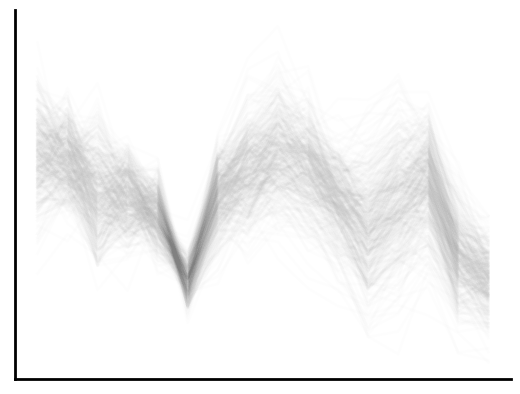

In [282]:
fullarray = pd_to_array(grad_pred_df)

fig = plt.figure(figsize=(3,2), dpi=1000)

abc = bootstrap_resample(fullarray, bootnum=1000)
plt.plot(np.mean(abc, axis=1).T, alpha=0.01, lw=2, color='grey')
# plt.plot(data.T,marker='o', linestyle='None')

# calculate conf interval
# cil, cir = bootstrap_ci(fullarray)
# plt.plot(cil, color='black', alpha=0.3, ls='--')
# plt.plot(cir, color='black', alpha=0.3, ls='--')
plt.plot(fullarray.mean(axis=0), color='black')

# Remove y-axis numbers
plt.yticks([])
plt.xticks([])

# Customize plot borders
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove top border
ax.spines['right'].set_visible(False)  # Remove right border
ax.spines['left'].set_linewidth(2)  # Make left border thicker
ax.spines['bottom'].set_linewidth(2)  # Make bottom border thicker

plt.show()


In [366]:

# grad_fir_df = grad_df(1)[['MRT24', 'MRT23',  'MLT24', 'MLT23', 'MLT34', 'pp', 'timepoint']]
# grad_adapt_df = grad_df(0)[['MRT24', 'MRT23', 'MRT34', 'MLT24', 'MLT23', 'MLT34', 'pp', 'timepoint']]
# grad_pred_df = grad_df(2)[['MRT21', 'MRT25', 'MLT21', 'MLT25', 'pp', 'timepoint']]
# grad_surp_df = grad_df(3)[['MRT35', 'MRT44', 'MRT43', 'MRT34', 'pp', 'timepoint']]

all_p = np.zeros([len(pps), 16])

for pp_idx in range(len(pps)):

    # select items
    pvalz = all_MNEs[pp_idx]['p_val_surprisal']
    layout = mne.channels.read_layout('CTF275.lay').names

    # get indexes of items of interest
    ite = ['MRT35', 'MRT44', 'MRT43', 'MRT34']
    ite_idx = [layout.index(item) for item in layout if item in ite]

    # take pvals
    all_p[pp_idx, :] = pvalz[ite_idx,:].mean(axis=0)
    
# get sig area
getsigvals = np.where(all_p.mean(axis=0) < 0.4)
getsigvals

(array([ 4,  5,  6, 10, 11, 12, 13]),)

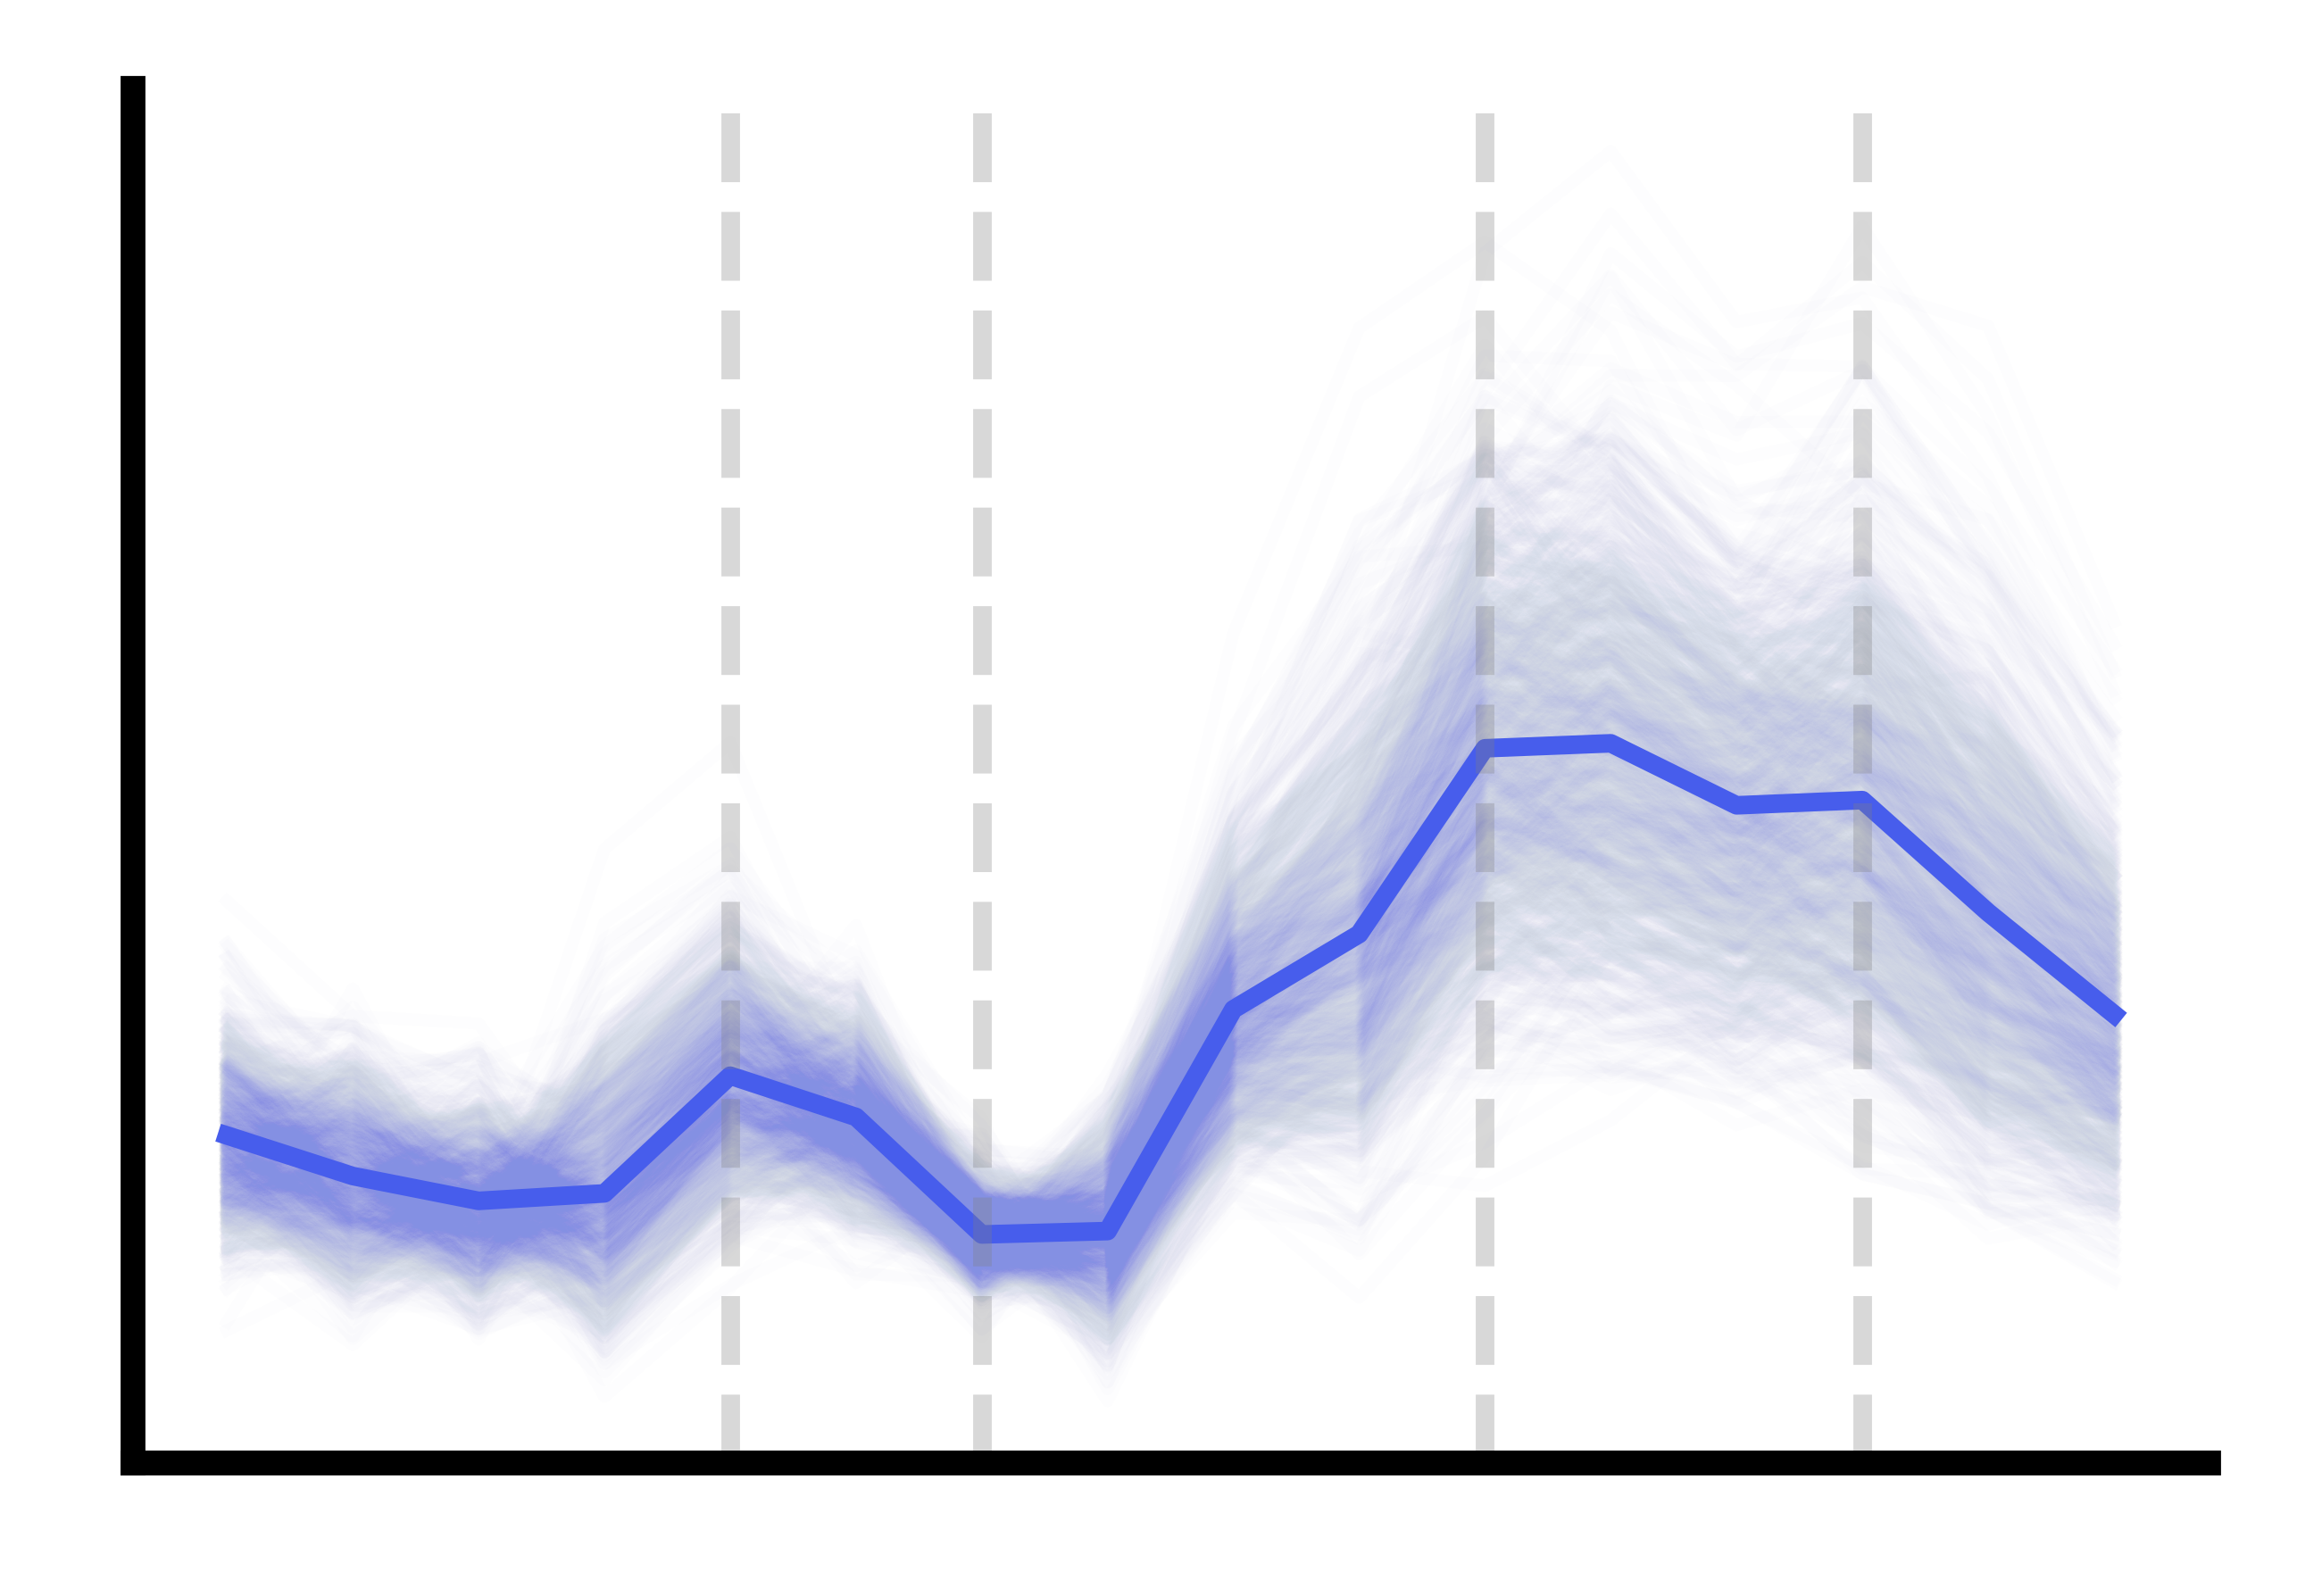

In [383]:
fullarray = pd_to_array(grad_surp_df)

fig = plt.figure(figsize=(3,2), dpi=1000)

abc = bootstrap_resample(fullarray, bootnum=1000)
plt.plot(np.mean(abc, axis=1).T, alpha=0.01, lw=1, color='#8490e3')
# plt.plot(data.T,marker='o', linestyle='None')

# calculate conf interval
# cil, cir = bootstrap_ci(fullarray)
# plt.plot(cil, color='black', alpha=0.3, ls='--')
# plt.plot(cir, color='black', alpha=0.3, ls='--')
plt.plot(fullarray.mean(axis=0), color='#475dec')

# Remove y-axis numbers
plt.yticks([])
plt.xticks([])

# Customize plot borders
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove top border
ax.spines['right'].set_visible(False)  # Remove right border
ax.spines['left'].set_linewidth(2)  # Make left border thicker
ax.spines['bottom'].set_linewidth(2)  # Make bottom border thicker

ax.axvline(4, color='grey', lw=1.5, alpha=0.3, ls='--')
ax.axvline(6, color='grey', lw=1.5, alpha=0.3, ls='--')
ax.axvline(10, color='grey', lw=1.5, alpha=0.3, ls='--')
ax.axvline(13, color='grey', lw=1.5, alpha=0.3, ls='--')


plt.show()


In [370]:

# grad_fir_df = grad_df(1)[['MRT24', 'MRT23',  'MLT24', 'MLT23', 'MLT34', 'pp', 'timepoint']]
# grad_adapt_df = grad_df(0)[['MRT24', 'MRT23', 'MRT34', 'MLT24', 'MLT23', 'MLT34', 'pp', 'timepoint']]
# grad_pred_df = grad_df(2)[['MRT21', 'MRT25', 'MLT21', 'MLT25', 'pp', 'timepoint']]
# grad_surp_df = grad_df(3)[['MRT35', 'MRT44', 'MRT43', 'MRT34', 'pp', 'timepoint']]

all_p = np.zeros([len(pps), 16])

for pp_idx in range(len(pps)):

    # select items
    pvalz = all_MNEs[pp_idx]['p_val_forward_adapted_activation']
    layout = mne.channels.read_layout('CTF275.lay').names

    # get indexes of items of interest
    ite = ['MRT24', 'MRT23', 'MRT34', 'MLT24', 'MLT23', 'MLT34']
    ite_idx = [layout.index(item) for item in layout if item in ite]

    # take pvals
    all_p[pp_idx, :] = pvalz[ite_idx,:].mean(axis=0)
    
# get sig area
getsigvals = np.where(all_p.mean(axis=0) < 0.4)
getsigvals

(array([ 6,  7,  8,  9, 10, 11, 12, 15]),)

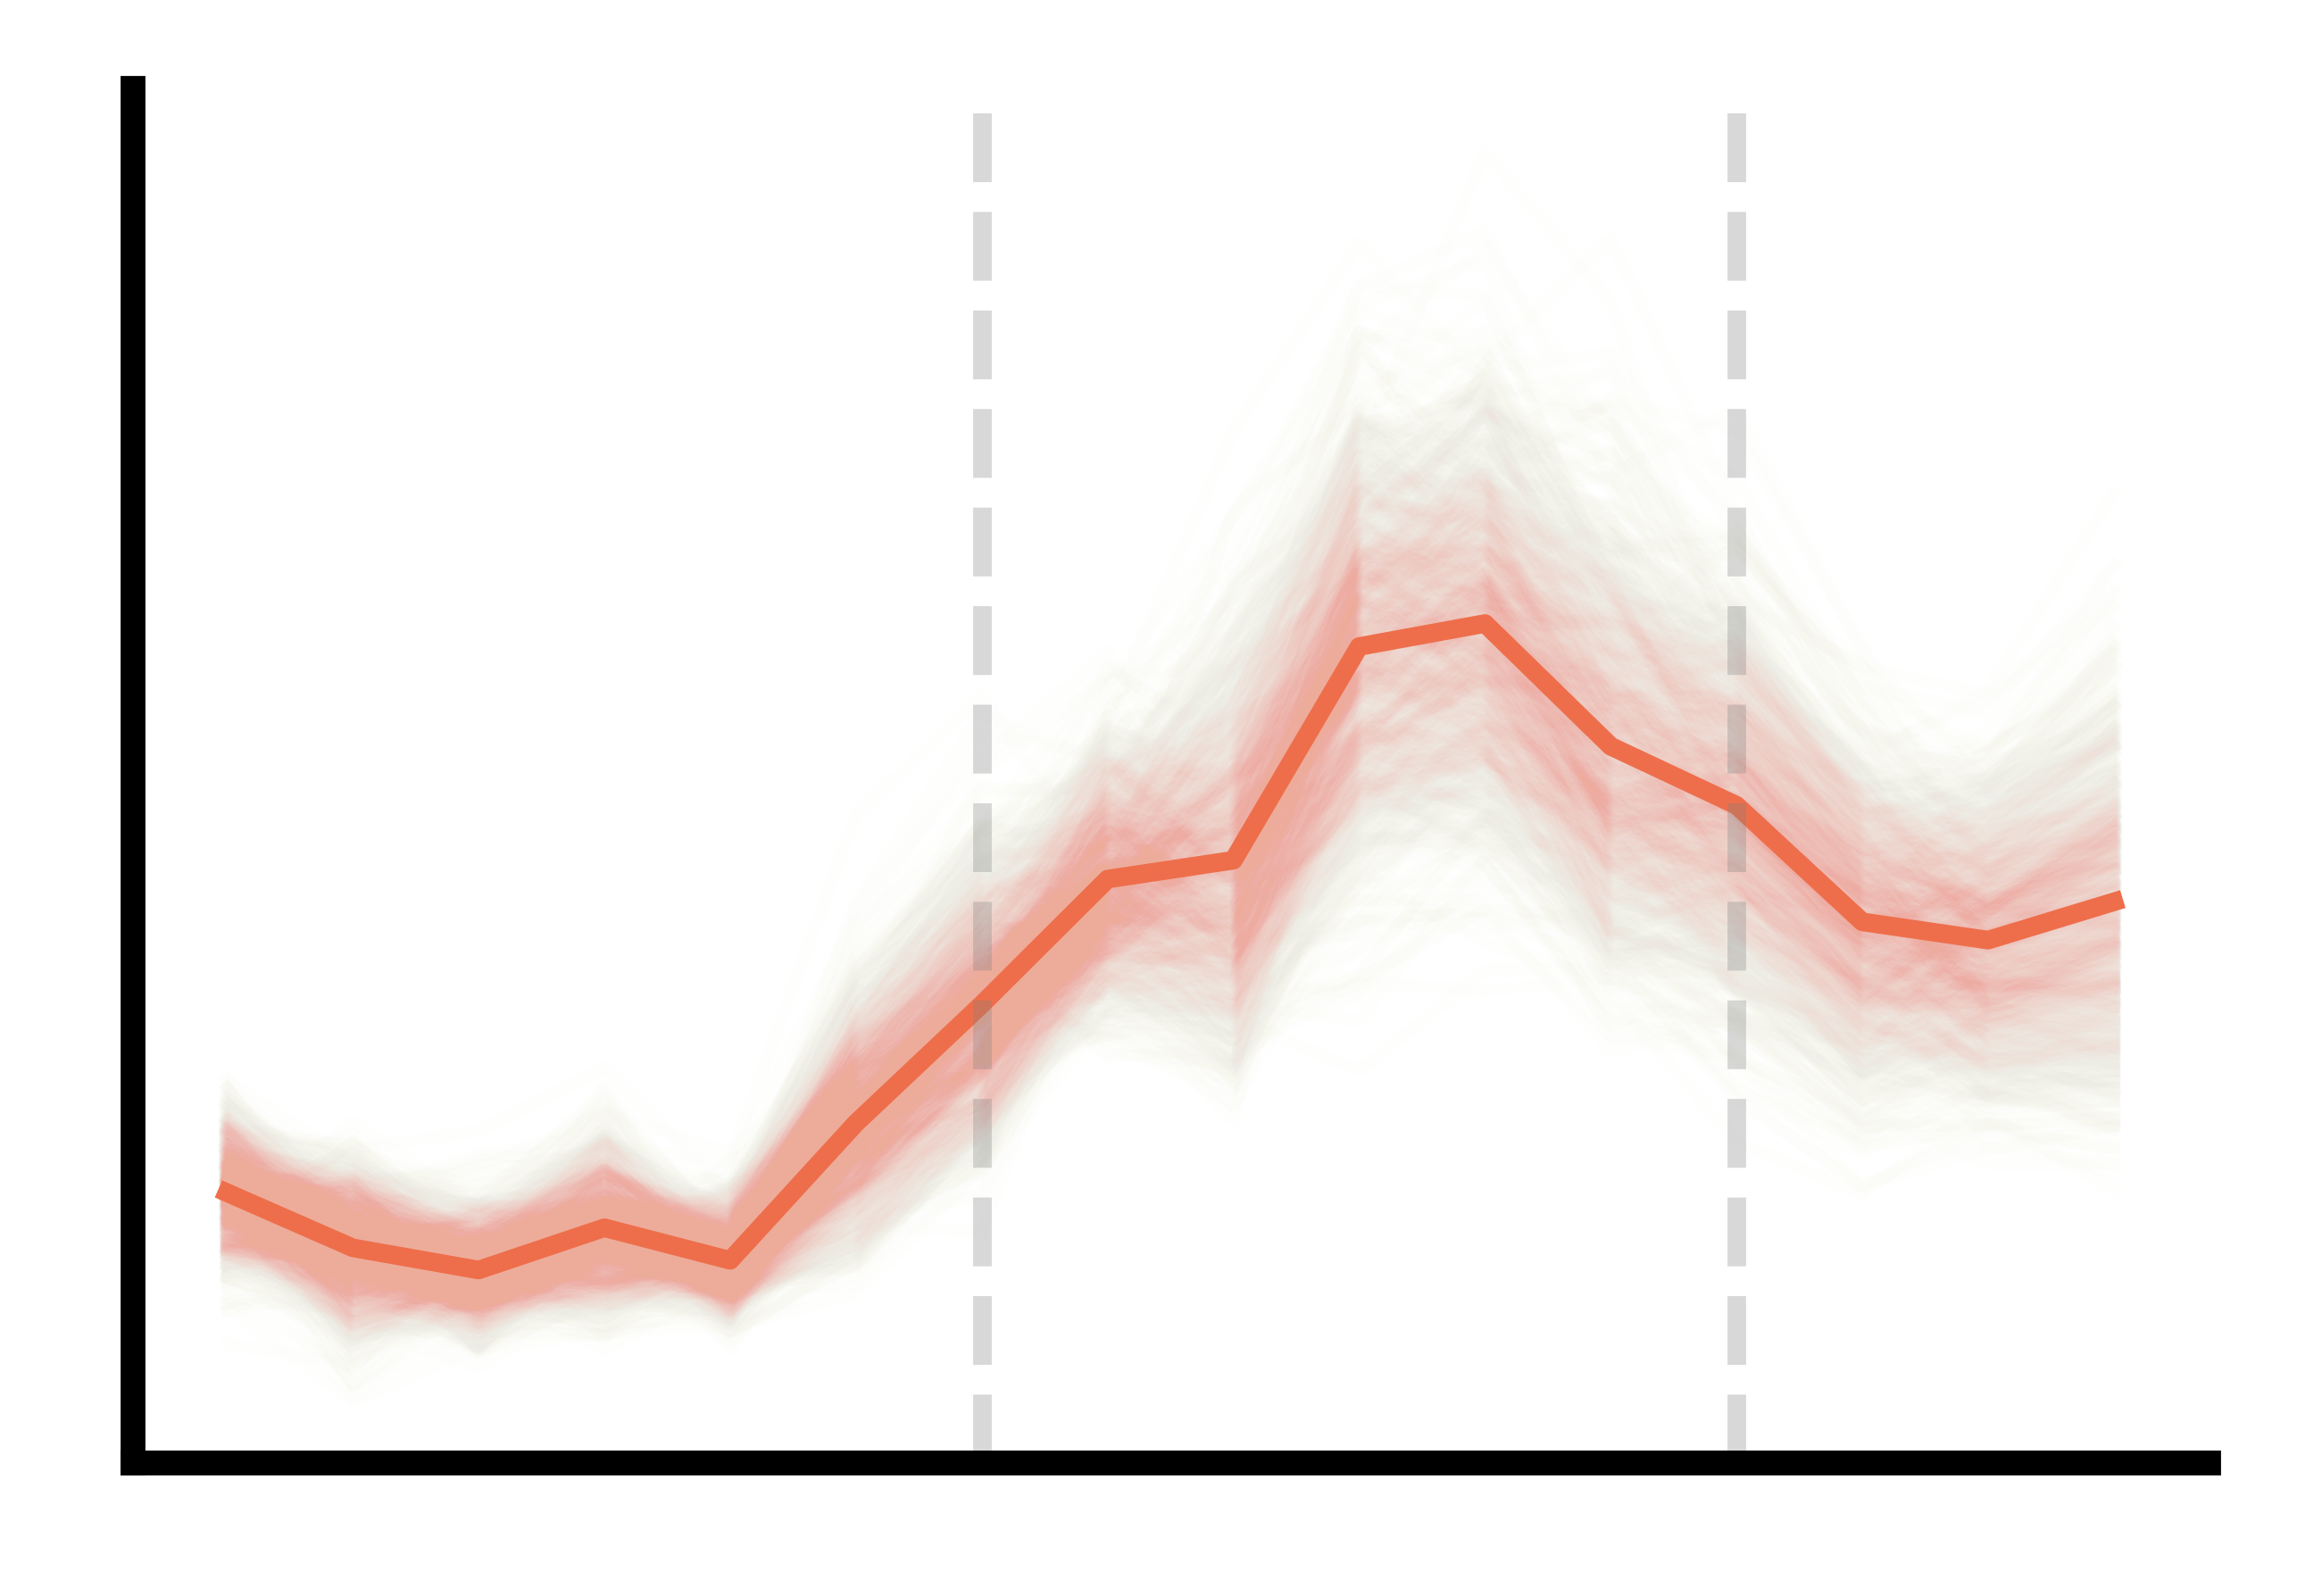

In [382]:
fullarray = pd_to_array(grad_adapt_df)

fig = plt.figure(figsize=(3,2), dpi=1000)

abc = bootstrap_resample(fullarray, bootnum=1000)
plt.plot(np.mean(abc, axis=1).T, alpha=0.01, lw=1, color='#edac9a')
# plt.plot(data.T,marker='o', linestyle='None')

# calculate conf interval
# cil, cir = bootstrap_ci(fullarray)
# plt.plot(cil, color='black', alpha=0.3, ls='--')
# plt.plot(cir, color='black', alpha=0.3, ls='--')
plt.plot(fullarray.mean(axis=0), color='#ee6e4b')

# Remove y-axis numbers
plt.yticks([])
plt.xticks([])

# Customize plot borders
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove top border
ax.spines['right'].set_visible(False)  # Remove right border
ax.spines['left'].set_linewidth(2)  # Make left border thicker
ax.spines['bottom'].set_linewidth(2)  # Make bottom border thicker

ax.axvline(6, color='grey', lw=1.5, alpha=0.3, ls='--')
ax.axvline(12, color='grey', lw=1.5, alpha=0.3, ls='--')

plt.show()


In [263]:
MNE_evokeds[0][0].times

array([-3.33333351e-02, -1.66666684e-02, -1.73846881e-09,  1.66666649e-02,
        3.33333316e-02,  4.99999983e-02,  6.66666649e-02,  8.33333316e-02,
        9.99999983e-02,  1.16666665e-01,  1.33333332e-01,  1.49999998e-01,
        1.66666665e-01,  1.83333332e-01,  1.99999998e-01,  2.16666665e-01])

In [211]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline

y = fullarray
x = np.arange(y.shape[1])  # Assuming equal spacing

spline_order = 3  # For cubic spline
num_cols = fullarray.shape[0]
x_fine = np.linspace(x.min(), x.max(), 300)  # Fine grid for interpolation

# Initialize an array to store the interpolated values
y_fine = np.zeros((len(x_fine), num_cols))

for i in range(num_cols):
    spline = InterpolatedUnivariateSpline(x, fullarray[i, :], k=spline_order)
    y_fine[:, i] = spline(x_fine)


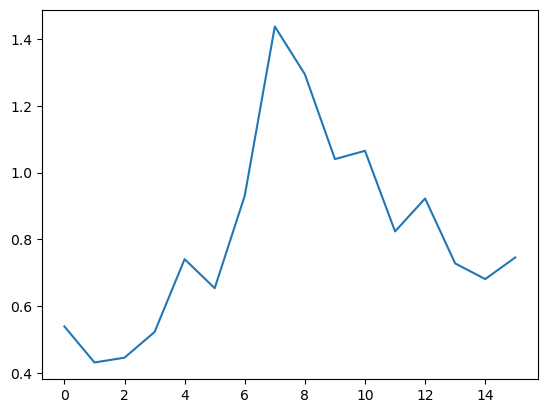

In [167]:
# get mean over sensors
np.mean(pp_array, axis=0)

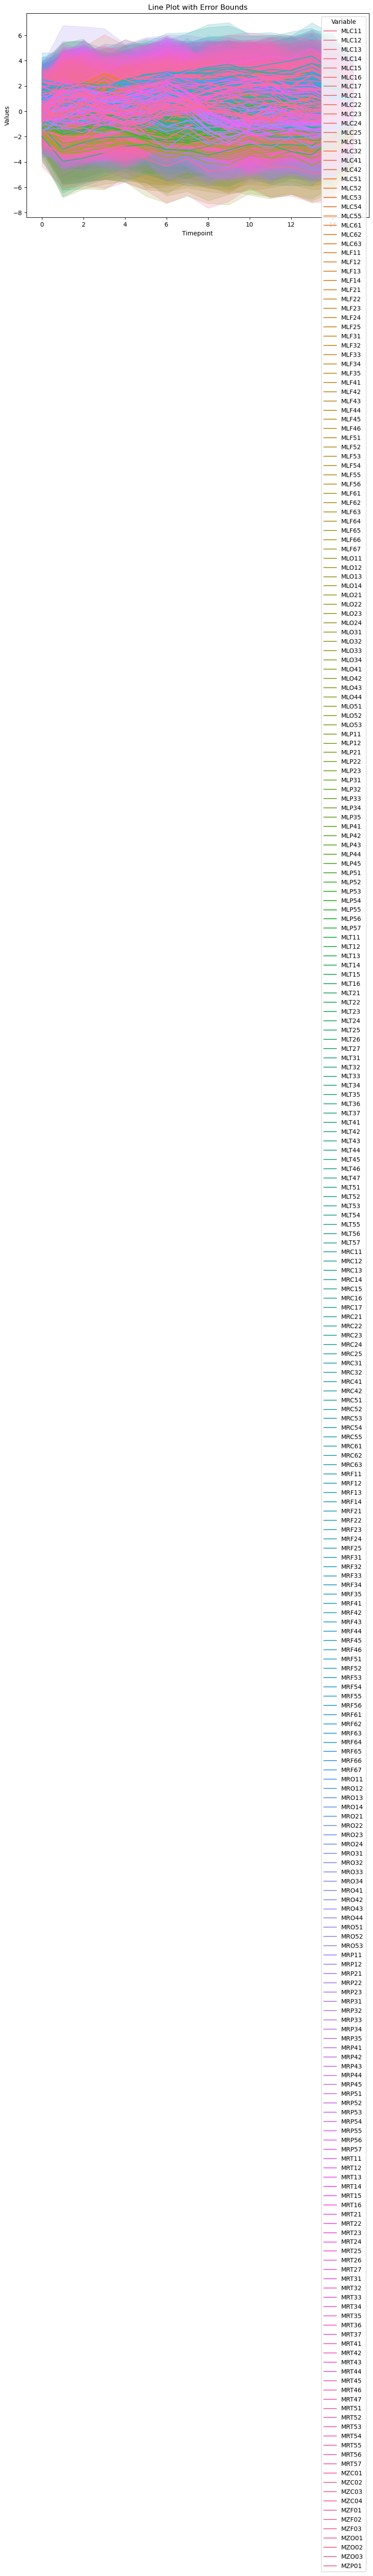

In [276]:

# Melt the DataFrame while keeping 'timepoint' and 'pp' as separate columns
long_df = df_dict['FIR_surprisal'].melt(id_vars=['timepoint', 'pp'], var_name='variable', value_name='value')

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=long_df, x='timepoint', y='value', hue='variable' ) #, err_style="band", estimator=None)

plt.xlabel('Timepoint')
plt.ylabel('Values')
plt.title('Line Plot with Error Bounds')
plt.legend(title='Variable')
plt.show()

In [185]:
import pickle
import mne

import pandas as pd
import numpy as np
import os
import itertools
import pickle
import sys
import scipy.stats 
from statsmodels.stats.api import multipletests


def bootstrap_ci(x,alpha=0.05,bootnum=10000,avgfun=np.mean):
    """compute confidence intervals around the mean/median using bootstrapping
    in:
    -x: ndarray, repetitions across first dimension
    -alpha: float. alpha level (1-alpha) confidence interval
    -bootnum: int. number of bootstraps (10000 default)
    -avgfun: callable (e.g. np.mean or np.median). requires 'axis' keyword
    
    out:
    -left,right: lower and upper bounds
    """

    bootfunc=lambda x: avgfun(x,axis=0)
    x_bootmean=bootstrap(x,bootfunc=bootfunc,bootnum=bootnum)
    left=np.percentile(x_bootmean,alpha/2*100,axis=0)
    right=np.percentile(x_bootmean,100-alpha/2*100,axis=0)
    return(left,right)

def bootstrap_se(x,bootnum=10000,avgfun=np.mean):
    """compute confidence standard error of the mean/median using bootstrapping
    in:
    -x: ndarray, repetitions across first dimension
    -alpha: float. alpha level (1-alpha) confidence interval
    -bootnum: int. number of bootstraps (10000 default)
    -avgfun: callable (e.g. np.mean or np.median). requires 'axis' keyword
    
    out:
    -left,right: lower and upper bounds
    """
    bootfunc=lambda x: avgfun(x,axis=0)
    x_bootmean=bootstrap(x,bootfunc=bootfunc,bootnum=bootnum)
    se=np.std(x_bootmean,axis=0)
    return(se)

def bootstrap_BET(samps_in,pop_mean=0,tail='2s',n_boots=10e4):
    """one-sample (paired) bootstrap t-test; returns p-value only
                    
    in:
    - samps: nd.array, shape(n_samples)
        datapoints 
    - pop_mean: float, Default=0
        mean to test against
    - tail: str, default: '2s'
        options: '2s','l','r' (for two-tailed,left or right-tailed)
    - n_boots: int; default=10e3
        number of bootstraps (determines precision)
    
    out:
    -pval: float 
        fraction of instances where simulated null distribution returns
        test statistic that is at least as extreme as emprical test stat.
        
    dependencies: bootstrap from astropy
    """
    seed = np.random.randint(1000)
    # test stat 
    t_func=lambda x,dim:(x.mean(dim)-pop_mean)/(x.std(dim)/np.sqrt(x.shape[dim]))
    # make null distribution 
    null_boot_test=t_func(bootstrap(samps_in-samps_in.mean(0)+pop_mean,bootnum=int(n_boots), 
                                    seed=seed),1)
    emp_test=t_func(samps_in,0)
    
    # make alt distribution
    alt_distr=bootstrap(samps_in,bootnum=int(n_boots), 
                        seed=seed)
    alpha_distr=alt_distr.mean()-null_boot_test

    # if distribution = 0
    if (alpha_distr>0).sum() == 0:
        omega = 1
    else:
        omega= (alpha_distr<=0).sum() / (alpha_distr>0).sum()

    # get mu, sigma and sample size
    mu = alpha_distr.mean()
    sigma = alpha_distr.std()
    n = len(samps_in)

    # calculate evidence strength
    evidence_strength = np.log( ((1-omega) * mu + (omega*sigma))   /   ((1 + omega * np.log(n)) * sigma))
    return(evidence_strength)

def bootstrap_t_onesample(samps_in,pop_mean=0,tail='2s',n_boots=10e4,seed=123):
    """one-sample (paired) bootstrap t-test; returns p-value only
                    
    in:
    - samps: nd.array, shape(n_samples)
        datapoints 
    - pop_mean: float, Default=0
        mean to test against
    - tail: str, default: '2s'
        options: '2s','l','r' (for two-tailed,left or right-tailed)
    - n_boots: int; default=10e3
        number of bootstraps (determines precision)
    
    out:
    -pval: float 
        fraction of instances where simulated null distribution returns
        test statistic that is at least as extreme as emprical test stat.
    see also:
    - fmt_boot_pval, function to format the pvalues, changes p=0 into P < (1/n_boots) statement 
    dependencies: bootstrap from astropy
    """
    t_func=lambda x:(x.mean(0)-pop_mean)/(x.std()/np.sqrt(x.shape[0]))

    # test stat 
    t_func=lambda x,dim:(x.mean(dim)-pop_mean)/(x.std(dim)/np.sqrt(x.shape[dim]))
    # make null distribution 
    null_boot_test=t_func(bootstrap(samps_in-samps_in.mean(0)+pop_mean,bootnum=int(n_boots),seed=seed),1)
    emp_test=t_func(samps_in,0)
    # return p-value as probability of obtaining a test stat at least as extreme under the null 
    if tail in ['2s','two','both']:
        left_pval=np.mean(null_boot_test<emp_test)
        right_pval=np.mean(null_boot_test>emp_test)
        return(2*min(left_pval,right_pval))
    elif tail.lower() in ['l','left']:
        return(np.mean(null_boot_test<emp_test))
    elif tail.lower() in ['r','right']:
        return(np.mean(null_boot_test>emp_test))
    else:
        raise ValueError('tail not recognised!')
        
flatten= lambda l: np.array([item for sublist in l for item in sublist])


def bootstrap(data, bootnum=1000, samples=None, bootfunc=None, seed=False):
    """Performs bootstrap resampling on numpy arrays. (FUNCTION FROM ASTROPY)

    Bootstrap resampling is used to understand confidence intervals of sample
    estimates. This function returns versions of the dataset resampled with
    replacement ("case bootstrapping"). These can all be run through a function
    or statistic to produce a distribution of values which can then be used to
    find the confidence intervals.

    Parameters
    ----------
    data : numpy.ndarray
        N-D array. The bootstrap resampling will be performed on the first
        index, so the first index should access the relevant information
        to be bootstrapped.
    bootnum : int, optional
        Number of bootstrap resamples
    samples : int, optional
        Number of samples in each resample. The default `None` sets samples to
        the number of datapoints
    bootfunc : function, optional
        Function to reduce the resampled data. Each bootstrap resample will
        be put through this function and the results returned. If `None`, the
        bootstrapped data will be returned

    Returns
    -------
    boot : numpy.ndarray

        If bootfunc is None, then each row is a bootstrap resample of the data.
        If bootfunc is specified, then the columns will correspond to the
        outputs of bootfunc.

    """
    if seed != False:
        np.random.seed(seed)
    
    if samples is None:
        samples = data.shape[0]

    # make sure the input is sane
    if samples < 1 or bootnum < 1:
        raise ValueError("neither 'samples' nor 'bootnum' can be less than 1.")

    if bootfunc is None:
        resultdims = (bootnum,) + (samples,) + data.shape[1:]
    else:
        # test number of outputs from bootfunc, avoid single outputs which are
        # array-like
        try:
            resultdims = (bootnum, len(bootfunc(data)))
        except TypeError:
            resultdims = (bootnum,)

    # create empty boot array
    boot = np.empty(resultdims)

    for i in range(bootnum):
        bootarr = np.random.randint(low=0, high=data.shape[0], size=samples)
        
#         if seed != False: print(bootarr)
        if bootfunc is None:
            boot[i] = data[bootarr]
        else:
            boot[i] = bootfunc(data[bootarr])

    return boot

In [186]:
def bootstrap_resample(data, bootnum=100, samples=None, seed=3333, ppdict=False):
    """Performs bootstrap resampling on numpy arrays.

    Bootstrap resampling is used to understand confidence intervals of sample
    estimates. This function returns versions of the dataset resampled with
    replacement ("case bootstrapping"). These can all be run through a function
    or statistic to produce a distribution of values which can then be used to
    find the confidence intervals.

    Parameters
    ----------
    data : numpy.ndarray
        N-D array. The bootstrap resampling will be performed on the first
        index, so the first index should access the relevant information
        to be bootstrapped.
    bootnum : int, optional
        Number of bootstrap resamples
    samples : int, optional
        Number of samples in each resample. The default `None` sets samples to
        the number of datapoints

    Returns
    -------
    boot : numpy.ndarray

    """
    np.random.seed(seed)
    
    if samples is None:
        samples = data.shape[0]

    resultdims = (bootnum,) + (samples,) + data.shape[1:]

    # create empty boot array
    boot = np.empty(resultdims)
    ppindx = np.empty(resultdims, dtype=object)
    
    for i in range(bootnum):
        bootarr = np.random.randint(low=0, high=data.shape[0], size=samples)
        boot[i] = data[bootarr]

        if ppdict != False: 
            #print(ppdict, bootarr)
            ppindx[i] = [ppdict[i] for i in bootarr]
        
    if not ppdict: return(boot)
    else: return(boot,ppindx)

def bootstrap_dict_items(score_dict, bootnum, samples=None, ppdict=False):
    
    if samples == 'match_min': samples=len(score_dict[min(score_dict, key=lambda k: len(score_dict[k]))])
    
    scores_boot = {}
    ppindx_boot = {}
    for i in score_dict.keys():
        if not ppdict: scores_boot[i] = bootstrap_resample(np.array(score_dict[i]), bootnum, samples=samples, ppdict=ppdict)
        else: scores_boot[i], ppindx_boot[i] = bootstrap_resample(np.array(score_dict[i]), bootnum, samples=samples, ppdict=ppdict[i])
        
    if not ppdict: return(scores_boot)
    else: return(scores_boot, ppindx_boot)

In [148]:
import numpy as np

# Set the random seed for reproducibility
np.random.seed(0)

# Parameters for dummy data generation
num_participants = 10
num_timepoints = 8

# Generate dummy data
# Each participant will have a linear trend over timepoints with added noise
timepoints = np.arange(num_timepoints)
data = np.array([0.5 * timepoints + np.random.normal(0, 0.5, num_timepoints) for _ in range(num_participants)])

data.shape


(10, 8)

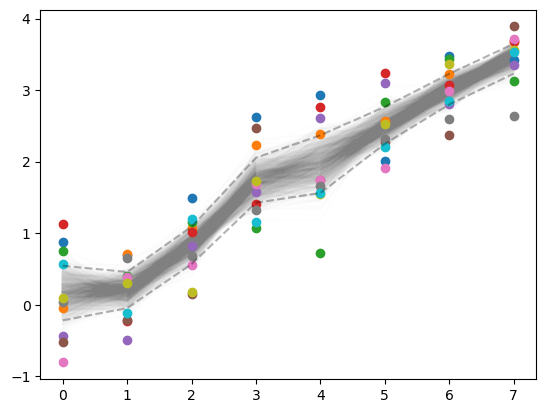

In [62]:
import matplotlib.pyplot as plt

abc = bootstrap_resample(data, bootnum=1000)
plt.plot(np.mean(abc, axis=1).T, alpha=0.01, color='grey')
plt.plot(data.T,marker='o', linestyle='None')

# calculate conf interval
cil, cir = bootstrap_ci(data)
plt.plot(cil, color='black', alpha=0.3, ls='--')
plt.plot(cir, color='black', alpha=0.3, ls='--')